In [1]:
# tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Add
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

2021-12-09 07:21:18.110581: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import librosa
import tensorflow as tf
import numpy as np
import os
from IPython import display as ipd

In [3]:
# gpu check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-12-09 07:21:19.922582: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-09 07:21:19.924022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-09 07:21:20.545899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 07:21:20.546686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-09 07:21:20.546728: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-09 07:21:20.550652: I tensorflow/stream_executor/platform/defau

In [4]:
train_size = 60000
BATCH_SIZE = 8 #수정
test_size = 10000
epochs = 200
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10

In [5]:
class Resnet1DBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(Resnet1DBlock, self).__init__(name='')
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [6]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,22500*10)),# 90001
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                # No activation
                layers.Conv1DTranspose(22500*10,1,1), #90001
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [7]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [8]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [9]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [10]:
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
        
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [11]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

2021-12-09 07:21:20.630704: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-09 07:21:20.631050: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 07:21:20.631754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-09 07:21:20.631803: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-09 07:21:20.631863: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-09 07:21:20.631876: I tensorflow/stream_executor/platform/de

In [12]:
model = CVAE(latent_dim)

In [13]:
BASE_DIR = '/home/jsryu1228/crawling/temp'

In [14]:
# 마지막 파일이 10초가 아닐 수 있기 때문에 제거
from natsort import natsorted

asmr_list = np.array(natsorted(os.listdir(BASE_DIR)))
train_data = [BASE_DIR + '/%s' % (x) for x in asmr_list]
train_data = train_data[:len(train_data) - 1]

In [15]:
len(train_data)

295

In [16]:
train = train_data[:145]
test = train_data[145:290]

print(len(train))
print(len(test))

assert len(train) == len(test)

145
145


In [17]:
import librosa.display

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveplot(wave[0], sr=22500)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [18]:
def wav_load(asmr):
    y, sampling_rate = librosa.load(asmr, sr=22500, offset=0.0, duration=10)
    y = y.reshape(1,22500*10)
    return y

map_func = lambda file: tf.compat.v1.py_func(wav_load, [file], [tf.float32])

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train = (
    tf.data.Dataset
    .from_tensor_slices(train)
    .map(map_func, num_parallel_calls=AUTOTUNE)
    .batch(8)
)

test = (
    tf.data.Dataset
    .from_tensor_slices(test)
    .map(map_func, num_parallel_calls=AUTOTUNE)
    .batch(8)
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [20]:
for test_batch in test.take(1):
    test_sample = test_batch[0]

2021-12-09 07:21:22.921032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-09 07:21:22.921526: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch: 85, Test set ELBO: nan, time elapse for current epoch: 21.928130865097046


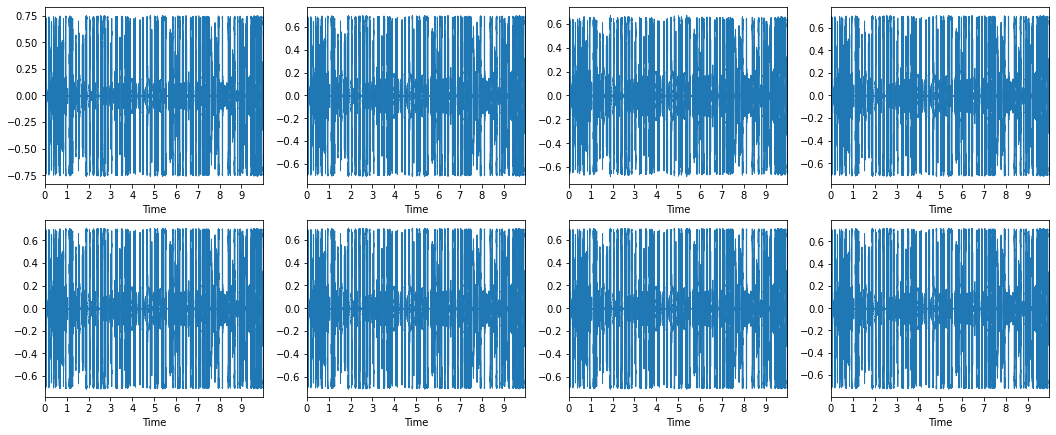

In [ ]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

generate_and_save_images(model, 0, test_sample, 'wave')

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train:
        train_x = np.asarray(train_x)[0]
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test:
        test_x = np.asarray(test_x)[0]
        loss(compute_loss(model, test_x))
    clear_output(wait=False)
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch,
                                                                                   elbo, 
                                                                                   end_time - start_time
                                                                                  ))
    generate_and_save_images(model, 
                             epoch, 
                             test_sample, 
                             'wave')

In [ ]:
save_asmr = []
for test_data in test:
    mean, logvar = model.encode(test_data)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    for pred in predictions:
        wave = np.asarray(pred)
        save_asmr.append(wave)

In [ ]:
asmr1=save_asmr[0][0]
ipd.Audio(asmr1,rate=22500)

In [ ]:
asmr2=save_asmr[1][0]
ipd.Audio(asmr2,rate=22500)

In [ ]:
asmr3=save_asmr[2][0]
ipd.Audio(asmr3,rate=22500)

In [ ]:
asmr4=save_asmr[3][0]
ipd.Audio(asmr4,rate=22500)

In [ ]:
asmr5=save_asmr[4][0]
ipd.Audio(asmr5,rate=22500)

In [ ]:
asmr6=save_asmr[5][0]
ipd.Audio(asmr6,rate=22500)

In [ ]:
asmr7=save_asmr[6][0]
ipd.Audio(asmr7,rate=22500)

In [ ]:
asmr8=save_asmr[7][0]
ipd.Audio(asmr7,rate=22500)

In [ ]:
asmr9=save_asmr[0]
ipd.Audio(asmr1,rate=22500)

In [ ]:
len(save_asmr)